In [70]:
# Notebook con la parte relevante de la clasificación de kaggle en el dataset son 4 fuentes de datos.
#
# https://www.kaggle.com/code/azizozmen/heart-failure-predict-8-classification-techniques
#
# En Anaconda Navigator instalar previamente, con el gestor de entornos, instalar los siguientes paquetes:
# matplotlib, seaborn, scikit-learn, 
# Tiene las modificaciones necesarias para poder instalar las bibliotecas faltantes usando pip3 y pip.
# En la celda 6 se indica el nombre del archivo a procesar, en este caso se toma como referencia el que puso Miguel en la
# carpeta compartida en OneDrive, y es el de kaggle que tiene 12 atributos, se contempla que está en el subdirectorio
# datasets, creado en el mismo nivel donde está almacenado este notebook.

!pip3 install --upgrade setuptools
!pip3 install pyforest xgboost cufflinks colorama
!pip3 install termcolor

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import pyforest
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, cross_val_predict, train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, mutual_info_regression
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)

# pd.set_option('display.max_rows', 100) # if you wish to see more rows rather than default, just uncomment this line.
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import colorama
from colorama import Fore, Style  # makes strings colored
from termcolor import colored

In [72]:
# Definición de parámetros para el procesamiento de los datos.
# Los datasets que son válidos así como fueron descargados son:
# kaggle_4_datasets_12_atrib.csv
# south_africa_heart_disease.csv
# faisalabad_heart_failure_clinical_records_dataset.csv
# 

# source_dataset = 1 -> Usar el dataset de UCI con 4 fuentes (Cleveland...)
# source_dataset = 2 -> Usar el dataset de South Africa.
# source_dataset = 3 -> Usar el dataset de Faisalabad.
# source_dataset = 4 -> Usar el dataset de Framingham.

source_dataset = 2

if source_dataset == 1:
  # Bloque de variables para el dataset de UCI que contiene 4 datasets.
  file_name = "kaggle_4_datasets_12_atrib.csv"        # Nombre del archivo, debe encontrarse en este mismo subdirectorio.
  pred_column_name = "heart_disease"               # Nombre de la columna de predicción.
if source_dataset == 2:
  # Bloque de variables para el dataset de Sudáfica.
  file_name = "south_africa_heart_disease.csv"     # Nombre del archivo, debe encontrarse en este mismo subdirectorio.
  pred_column_name = "chd"                         # Nombre de la columna de predicción.
if source_dataset == 3:
  # Bloque de variables para el dataset de Faisalabad.
  file_name = "faisalabad_heart_failure_clinical_records_dataset.csv"
  pred_column_name = "DEATH_EVENT"
if source_dataset == 4:
  file_name = "framingham_chd_preprocessed_data.csv"
  pred_column_name = "TenYearCHD"

test_split_size = 0.20                           # Porcentaje para test - train (20% - 80%) = 0.20
random_state = 0                                 # Valor a usar para la semilla de los algoritmos.
cross_validate_size = 10                         # Valor de k a usar para el algoritmo k-cross-fold-validation.
threshold_skew_limit = 0.5                       # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
threshold_kurtosis_limit = 7                     # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
knn_neighbors = 3                                # Número de vecinos a usar en algoritmo KNN.
ada_boosting_estimators = 50                     # Número de estimators a usar en AdaBoosting.
random_forest_estimators = 10                    # Número de estimators a usar en RandomForest.
svm_c_values = [0.1, 1, 10, 100, 1000]           # Valores a usar para el algoritmo SVM.
learning_rates = [0.05, 0.1, 0.15, 0.25, 0.5, 0.6, 0.75, 0.85, 1]

In [73]:
# Function for determining the number and percentages of missing values

def missing (data_frame):
    missing_number = data_frame.isnull().sum().sort_values(ascending=False)
    missing_percent = (data_frame.isnull().sum()/data_frame.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['missing_number', 'missing_Percent'])
    return missing_values

In [74]:
# Function for insighting summary information about the column

def first_looking(data_frame, column):
    print("column name    : ", column)
    print("----------------------------------------------------")
    print("per_of_nulls   : ", "%", round(data_frame[column].isnull().sum()/data_frame.shape[0]*100, 2))
    print("num_of_nulls   : ", data_frame[column].isnull().sum())
    print("num_of_uniques : ", data_frame[column].nunique())
    print(data_frame[column].value_counts(dropna = False))

In [75]:
# Function for examining scores

def train_val(y_train, y_train_pred, y_test, y_pred):
    scores = {
        "train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                      "Precision" : precision_score(y_train, y_train_pred),
                      "Recall" : recall_score(y_train, y_train_pred),                          
                      "f1" : f1_score(y_train, y_train_pred)},
    
        "test_set":  {"Accuracy" : accuracy_score(y_test, y_pred),
                      "Precision" : precision_score(y_test, y_pred),
                      "Recall" : recall_score(y_test, y_pred),                          
                      "f1" : f1_score(y_test, y_pred)}
    }
    
    return pd.DataFrame(scores)

In [76]:
df0 = pd.read_csv(file_name)


In [77]:
df = df0

In [78]:
# Desplegar los primeros registros así como los últimos.
df.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
0,40,M,ATA,140,289,0,Normal,172,N,0.000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000,Up,0


In [79]:
df.tail()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
913,45,M,TA,110,264,0,Normal,132,N,1.200,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.400,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.200,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.000,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.000,Up,0


In [80]:
df.sample(10)

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
365,64,F,ASY,200,0,0,Normal,140,Y,1.000,Flat,1
776,62,F,ASY,150,244,0,Normal,154,Y,1.400,Flat,1
642,51,F,NAP,120,295,0,LVH,157,N,0.600,Up,0
597,55,M,NAP,133,185,0,ST,136,N,0.200,Up,0
459,41,M,ASY,104,0,0,ST,111,N,0.000,Up,0
297,57,M,ASY,110,0,1,ST,131,Y,1.400,Up,1
413,56,M,NAP,125,0,1,Normal,98,N,-2.000,Flat,1
755,64,M,ASY,145,212,0,LVH,132,N,2.000,Flat,1
896,47,M,NAP,130,253,0,Normal,179,N,0.000,Up,0
854,52,M,ATA,120,325,0,Normal,172,N,0.200,Up,0


In [81]:
df.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol',
       'fasting_bs', 'resting_ecg', 'max_hr', 'exercise_angina', 'oldpeak',
       'st_slope', 'heart_disease'],
      dtype='object')

In [82]:
print("There is", df.shape[0], "observation and", df.shape[1], "columns in the dataset")

There is 918 observation and 12 columns in the dataset


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              918 non-null    int64  
 1   sex              918 non-null    object 
 2   chest_pain_type  918 non-null    object 
 3   resting_bp       918 non-null    int64  
 4   cholesterol      918 non-null    int64  
 5   fasting_bs       918 non-null    int64  
 6   resting_ecg      918 non-null    object 
 7   max_hr           918 non-null    int64  
 8   exercise_angina  918 non-null    object 
 9   oldpeak          918 non-null    float64
 10  st_slope         918 non-null    object 
 11  heart_disease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [84]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,918.000,53.511,9.433,28.000,47.000,54.000,60.000,77.000
resting_bp,918.000,132.397,18.514,0.000,120.000,130.000,140.000,200.000
cholesterol,918.000,198.800,109.384,0.000,173.250,223.000,267.000,603.000
fasting_bs,918.000,0.233,0.423,0.000,0.000,0.000,0.000,1.000
max_hr,918.000,136.809,25.460,60.000,120.000,138.000,156.000,202.000
oldpeak,918.000,0.887,1.067,-2.600,0.000,0.600,1.500,6.200
heart_disease,918.000,0.553,0.497,0.000,0.000,1.000,1.000,1.000


In [85]:
try:
  df.describe(include=object).T
except:
  print("The dataset does not contain categorical columns")

In [86]:
df.nunique()

age                 50
sex                  2
chest_pain_type      4
resting_bp          67
cholesterol        222
fasting_bs           2
resting_ecg          3
max_hr             119
exercise_angina      2
oldpeak             53
st_slope             3
heart_disease        2
dtype: int64

In [87]:
# to find how many unique values object features have

for column in df.select_dtypes(include=[np.number]).columns:
  print(f"{column} has {df[column].nunique()} unique value")

age has 50 unique value
resting_bp has 67 unique value
cholesterol has 222 unique value
fasting_bs has 2 unique value
max_hr has 119 unique value
oldpeak has 53 unique value
heart_disease has 2 unique value


In [88]:
# Determinar el número de renglones duplicados
df.duplicated().value_counts()

False    918
dtype: int64

In [89]:
# Determinar si hay valores omitidos.
missing (df)

,missing_number,missing_Percent
age,0,0.000
sex,0,0.000
chest_pain_type,0,0.000
resting_bp,0,0.000
cholesterol,0,0.000
fasting_bs,0,0.000
resting_ecg,0,0.000
max_hr,0,0.000
exercise_angina,0,0.000
oldpeak,0,0.000


In [90]:
# Mostrar información del atributo que se va a predecir.
first_looking(df, pred_column_name)

column name    :  heart_disease
----------------------------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
1    508
0    410
Name: heart_disease, dtype: int64


1    508
0    410
Name: heart_disease, dtype: int64


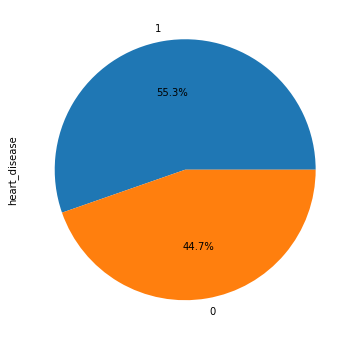

In [91]:
print(df[pred_column_name].value_counts())
df[pred_column_name].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(6,6));

In [92]:
y = df[pred_column_name]
print(f'Percentage of Heart Disease: % {round(y.value_counts(normalize=True)[1]*100,2)} --> \
({y.value_counts()[1]} cases for Heart Disease)\nPercentage of NOT Heart Disease: % {round(y.value_counts(normalize=True)[0]*100,2)} --> ({y.value_counts()[0]} cases for NOT Heart Disease)')

Percentage of Heart Disease: % 55.34 --> (508 cases for Heart Disease)
Percentage of NOT Heart Disease: % 44.66 --> (410 cases for NOT Heart Disease)


In [93]:
df[pred_column_name].describe()

count   918.000
mean      0.553
std       0.497
min       0.000
25%       0.000
50%       1.000
75%       1.000
max       1.000
Name: heart_disease, dtype: float64

In [94]:
df[df[pred_column_name]==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
age,410.000000,50.551220,9.444915,28.000000,43.000000,51.000000,57.000000,76.000000
resting_bp,410.000000,130.180488,16.499585,80.000000,120.000000,130.000000,140.000000,190.000000
cholesterol,410.000000,227.121951,74.634659,0.000000,197.250000,227.000000,266.750000,564.000000
fasting_bs,410.000000,0.107317,0.309894,0.000000,0.000000,0.000000,0.000000,1.000000
max_hr,410.000000,148.151220,23.288067,69.000000,134.000000,150.000000,165.000000,202.000000
oldpeak,410.000000,0.408049,0.699709,-1.100000,0.000000,0.000000,0.600000,4.200000
heart_disease,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [95]:
df[df[pred_column_name]==1].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
age,508.000000,55.899606,8.727056,31.000000,51.000000,57.000000,62.000000,77.000000
resting_bp,508.000000,134.185039,19.828685,0.000000,120.000000,132.000000,145.000000,200.000000
cholesterol,508.000000,175.940945,126.391398,0.000000,0.000000,217.000000,267.000000,603.000000
fasting_bs,508.000000,0.334646,0.472332,0.000000,0.000000,0.000000,1.000000,1.000000
max_hr,508.000000,127.655512,23.386923,60.000000,112.000000,126.000000,144.250000,195.000000
oldpeak,508.000000,1.274213,1.151872,-2.600000,0.000000,1.200000,2.000000,6.200000
heart_disease,508.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [96]:
print( f"Skewness: {df[pred_column_name].skew()}")

Skewness: -0.21508633825088655


In [97]:
print( f"Kurtosis: {df[pred_column_name].kurtosis()}")

Kurtosis: -1.9580084425329685


In [98]:
df[pred_column_name].iplot(kind='hist')

In [99]:
numerical= df.drop([pred_column_name], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['age', 'resting_bp', 'cholesterol', 'fasting_bs', 'max_hr', 'oldpeak'], dtype='object')


Categorical Columns: Index(['sex', 'chest_pain_type', 'resting_ecg', 'exercise_angina', 'st_slope'], dtype='object')


In [100]:
df[numerical].head().T

,0,1,2,3,4
age,40.000,49.000,37.000,48.000,54.000
resting_bp,140.000,160.000,130.000,138.000,150.000
cholesterol,289.000,180.000,283.000,214.000,195.000
fasting_bs,0.000,0.000,0.000,0.000,0.000
max_hr,172.000,156.000,98.000,108.000,122.000
oldpeak,0.000,1.000,0.000,1.500,0.000


In [101]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
age,918.000,53.511,9.433,28.000,47.000,54.000,60.000,77.000
resting_bp,918.000,132.397,18.514,0.000,120.000,130.000,140.000,200.000
cholesterol,918.000,198.800,109.384,0.000,173.250,223.000,267.000,603.000
fasting_bs,918.000,0.233,0.423,0.000,0.000,0.000,0.000,1.000
max_hr,918.000,136.809,25.460,60.000,120.000,138.000,156.000,202.000
oldpeak,918.000,0.887,1.067,-2.600,0.000,0.600,1.500,6.200


In [102]:
df[numerical].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
age,918.000000,53.510893,9.432617,28.000000,47.000000,54.000000,60.000000,77.000000
resting_bp,918.000000,132.396514,18.514154,0.000000,120.000000,130.000000,140.000000,200.000000
cholesterol,918.000000,198.799564,109.384145,0.000000,173.250000,223.000000,267.000000,603.000000
fasting_bs,918.000000,0.233115,0.423046,0.000000,0.000000,0.000000,0.000000,1.000000
max_hr,918.000000,136.809368,25.460334,60.000000,120.000000,138.000000,156.000000,202.000000
oldpeak,918.000000,0.887364,1.066570,-2.600000,0.000000,0.600000,1.500000,6.200000


In [103]:
df[numerical].iplot(kind='hist');

In [104]:
df[numerical].iplot(kind='histogram', subplots=True,bins=50)

In [105]:
for i in numerical:
    df[i].iplot(kind="box", title=i, boxpoints="all", color='lightseagreen')

Numero de atributos: 6


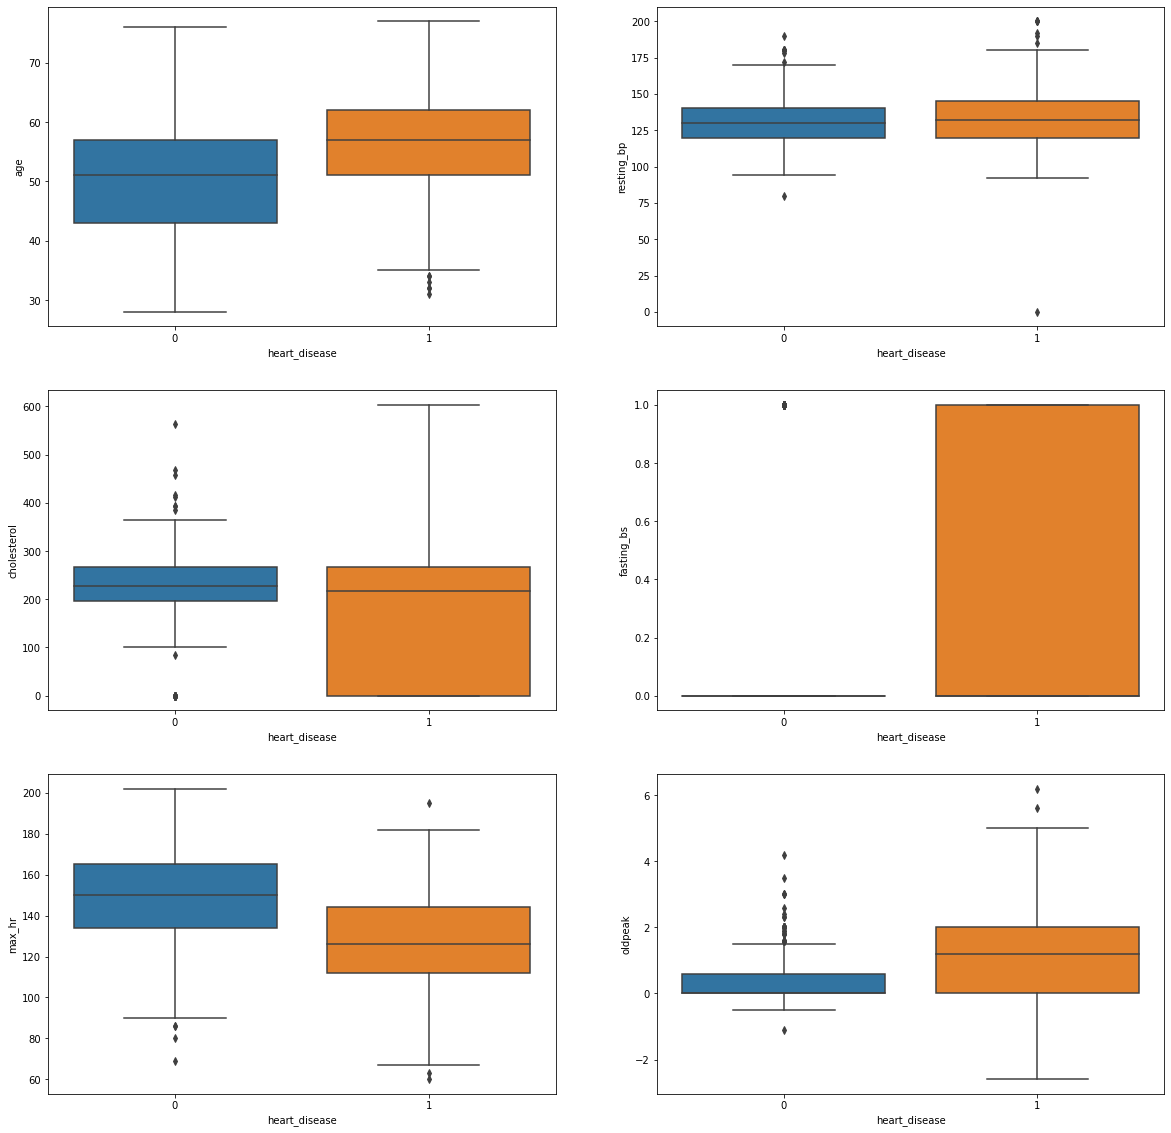

In [106]:
index = 0
figs_per_row = 2
print("Numero de atributos:", numerical.size)
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != pred_column_name:
        index += 1
        plt.subplot(numerical.size // figs_per_row, figs_per_row, index)
        sns.boxplot(x=pred_column_name, y=feature, data=df)

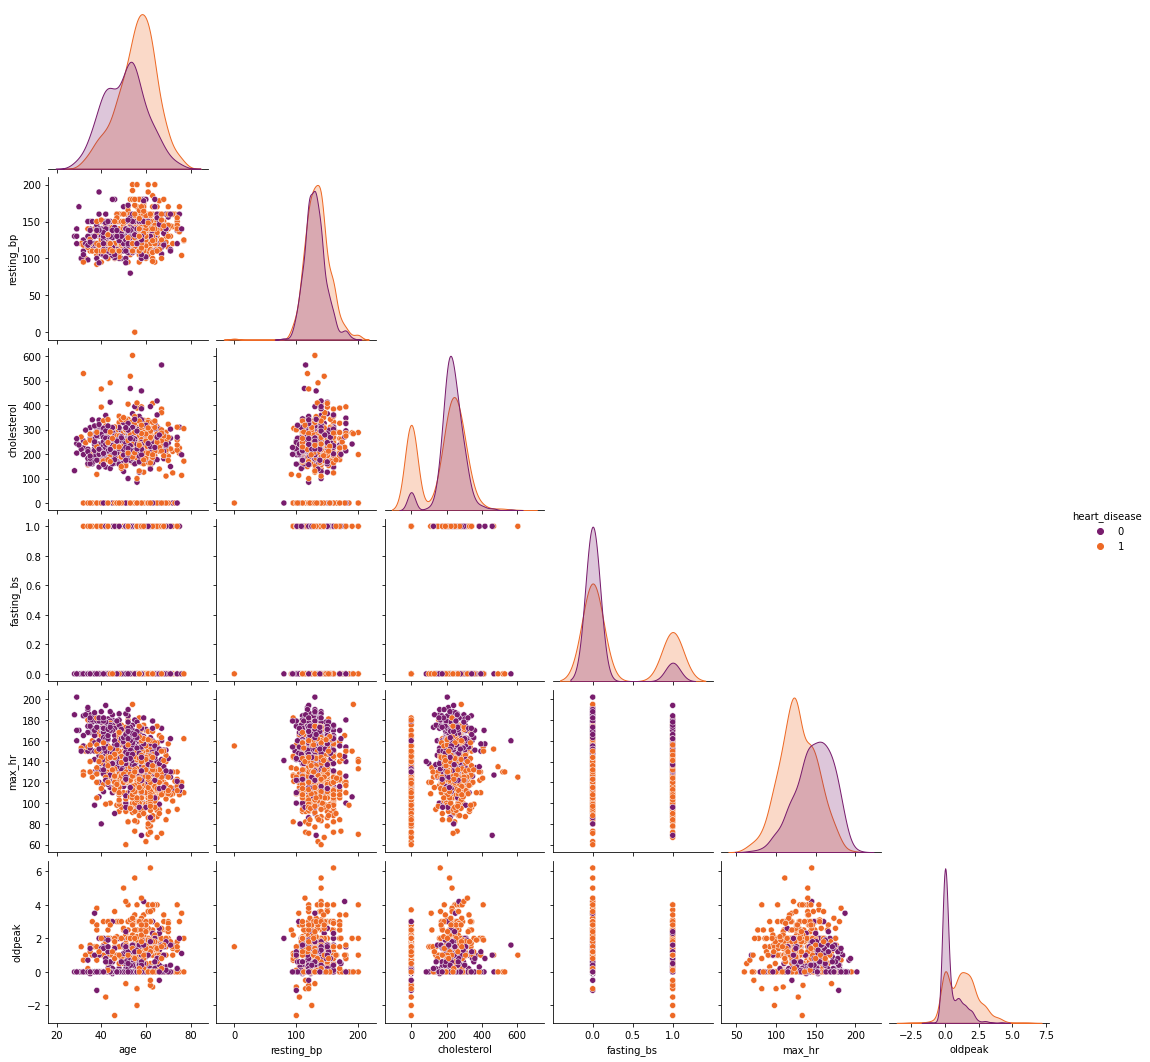

In [107]:
sns.pairplot(df, hue=pred_column_name, palette="inferno", corner=True);

In [108]:
skew_vals = df.skew().sort_values(ascending=False)
skew_vals

fasting_bs       1.264
oldpeak          1.023
resting_bp       0.180
max_hr          -0.144
age             -0.196
heart_disease   -0.215
cholesterol     -0.610
dtype: float64

In [109]:
# This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
skew_limit = threshold_skew_limit
skew_vals = df.skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols 

fasting_bs     1.264
oldpeak        1.023
cholesterol   -0.610
dtype: float64

In [110]:
#Interpreting Skewness 

for skew in skew_vals:
    if -threshold_skew_limit < skew < threshold_skew_limit:
        print ("A skewness value of", '\033[1m', Fore.GREEN, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.GREEN, "symmetric", '\033[0m')
    elif  -threshold_skew_limit < skew < -1.0 or threshold_skew_limit < skew < 1.0:
        print ("A skewness value of", '\033[1m', Fore.YELLOW, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.YELLOW, "moderately skewed", '\033[0m')
    else:
        print ("A skewness value of", '\033[1m', Fore.RED, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.RED, "highly skewed", '\033[0m')

A skewness value of   -0.19593302867569365  means that the distribution is approx.   symmetric 
A skewness value of   0.1798393100516288  means that the distribution is approx.   symmetric 
A skewness value of   -0.6100864307268192  means that the distribution is approx.   highly skewed 
A skewness value of   1.2644841750727027  means that the distribution is approx.   highly skewed 
A skewness value of   -0.14435941846180994  means that the distribution is approx.   symmetric 
A skewness value of   1.0228720218107528  means that the distribution is approx.   highly skewed 
A skewness value of   -0.21508633825088655  means that the distribution is approx.   symmetric 


In [111]:
kurtosis_vals = df.kurtosis().sort_values(ascending=False)
kurtosis_vals

resting_bp       3.271
oldpeak          1.203
cholesterol      0.118
age             -0.386
fasting_bs      -0.402
max_hr          -0.448
heart_disease   -1.958
dtype: float64

In [112]:
# Calculating Kurtosis 

# This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
kurtosis_limit = threshold_kurtosis_limit 
kurtosis_vals = df.kurtosis()
kurtosis_cols = kurtosis_vals[abs(kurtosis_vals) > kurtosis_limit].sort_values(ascending=False)
kurtosis_cols

Series([], dtype: float64)

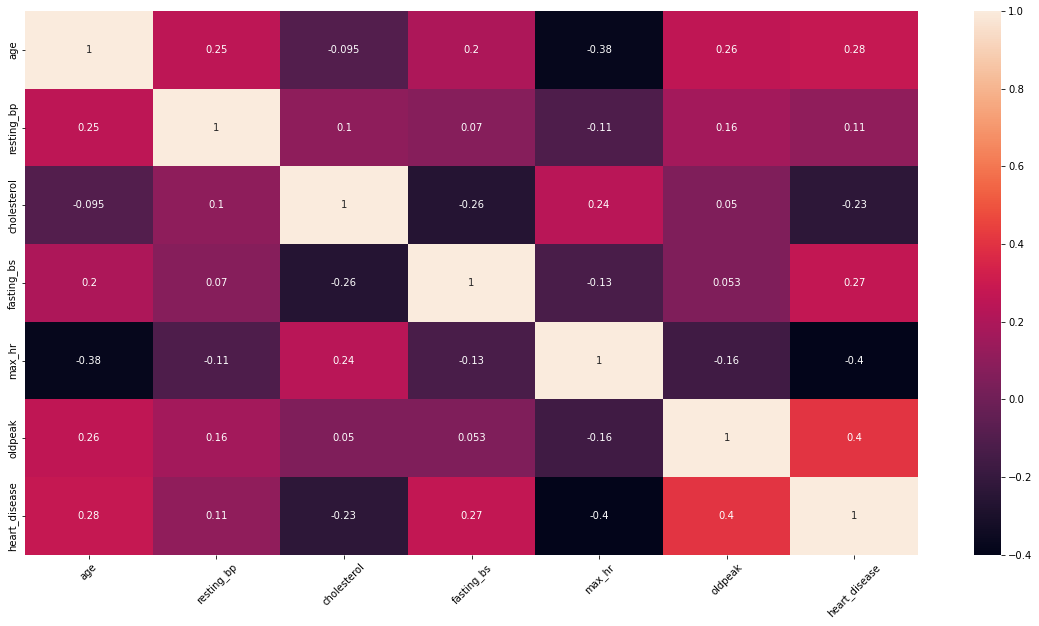

In [113]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)
plt.xticks(rotation=45);

In [114]:
df_temp = df.corr()

count = "Done"
feature =[]
collinear=[]
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i]> .9 and df_temp[col][i] < 1) or (df_temp[col][i]< -.9 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                print(Fore.RED + f"\033[1mmulticolinearity alert in between\033[0m {col} - {i}")
        else:
            print(f"For {col} and {i}, there is NO multicollinearity problem") 

print("\033[1mThe number of strong corelated features:\033[0m", count) 

For age and age, there is NO multicollinearity problem
For age and resting_bp, there is NO multicollinearity problem
For age and cholesterol, there is NO multicollinearity problem
For age and fasting_bs, there is NO multicollinearity problem
For age and max_hr, there is NO multicollinearity problem
For age and oldpeak, there is NO multicollinearity problem
For age and heart_disease, there is NO multicollinearity problem
For resting_bp and age, there is NO multicollinearity problem
For resting_bp and resting_bp, there is NO multicollinearity problem
For resting_bp and cholesterol, there is NO multicollinearity problem
For resting_bp and fasting_bs, there is NO multicollinearity problem
For resting_bp and max_hr, there is NO multicollinearity problem
For resting_bp and oldpeak, there is NO multicollinearity problem
For resting_bp and heart_disease, there is NO multicollinearity problem
For cholesterol and age, there is NO multicollinearity problem
For cholesterol and resting_bp, there is

In [115]:
# TODO: Algo está mal con este condicional, porque arma desmadre.
# if (categorical.shape[0] != 0):
df[categorical].head().T

,0,1,2,3,4
sex,M,F,M,F,M
chest_pain_type,ATA,NAP,ATA,ASY,NAP
resting_ecg,Normal,Normal,ST,Normal,Normal
exercise_angina,N,N,N,Y,N
st_slope,Up,Flat,Up,Flat,Up


In [116]:
print("Number of categorical attrib: ", categorical.shape[0])
categorical_count = categorical.shape[0]

Number of categorical attrib:  5


In [117]:
# if (categorical.shape[0] != 0):
# Remove categorical columns, replace using dummies variables.
df = pd.get_dummies(df, drop_first=True)

In [118]:
X = df.drop([pred_column_name], axis=1)
y = df[pred_column_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_size, stratify = y, random_state = random_state)
missing(df)

,missing_number,missing_Percent
age,0,0.000
resting_bp,0,0.000
cholesterol,0,0.000
fasting_bs,0,0.000
max_hr,0,0.000
oldpeak,0,0.000
heart_disease,0,0.000
sex_M,0,0.000
chest_pain_type_ATA,0,0.000
chest_pain_type_NAP,0,0.000


In [119]:
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [120]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("X_train_scaled size:", X_train_scaled.shape)
print("X_test_scaled size:", X_test_scaled.shape)

X_train_scaled size: (734, 15)
X_test_scaled size: (184, 15)


In [121]:
# General Insights

def model_first_insight(X_train, y_train, class_weight, solver='liblinear'):
    # Logistic Regression
    log = LogisticRegression(random_state=random_state, class_weight=class_weight)
    log.fit(X_train, y_train)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=random_state, class_weight=class_weight)
    decision_tree.fit(X_train, y_train)
   
    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=random_forest_estimators, criterion = 'entropy', random_state=random_state, class_weight=class_weight)
    random_forest.fit(X_train, y_train)
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors = knn_neighbors)
    knn.fit(X_train, y_train) 
   
    # SVC
    svc = SVC(random_state=random_state, class_weight=class_weight)
    svc.fit(X_train, y_train) 
    
    # XGB
    xgb = XGBClassifier(random_state=random_state, class_weight=class_weight)
    xgb.fit(X_train, y_train)
    
    # AdaBoosting
    ab = AdaBoostClassifier(n_estimators=ada_boosting_estimators, random_state=random_state)
    ab.fit(X_train, y_train)
    
    # GB GradientBoosting
    gb = GradientBoostingClassifier(random_state=random_state)
    gb.fit(X_train, y_train)
    
    # Model Accuracy on Training Data
    print(f"\033[1m1) Logistic Regression Training Accuracy:\033[0m {log.score(X_train, y_train)}")
    print(f"\033[1m2) SVC Training Accuracy:\033[0m {svc.score(X_train, y_train)}")    
    print(f"\033[1m3) Decision Tree Training Accuracy:\033[0m {decision_tree.score(X_train, y_train)}")
    print(f"\033[1m4) Random Forest Training Accuracy:\033[0m {random_forest.score(X_train, y_train)}")
    print(f"\033[1m5) KNN Training Accuracy:\033[0m {knn.score(X_train, y_train)}")
    print(f"\033[1m6) GradiendBoosting Training Accuracy:\033[0m {gb.score(X_train, y_train)}")
    print(f"\033[1m7) AdaBoosting Training Accuracy:\033[0m {ab.score(X_train, y_train)}")
    print(f"\033[1m8) XGBoosting Training Accuracy:\033[0m {xgb.score(X_train, y_train)}")
    
    return log, svc, decision_tree, random_forest, knn, gb, ab, xgb

In [122]:
def models(X_train, y_train, class_weight):
    # Logistic Regression
    log = LogisticRegression(random_state=random_state, class_weight=class_weight, solver='liblinear')
    log.fit(X_train, y_train)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=random_state, class_weight=class_weight)
    decision_tree.fit(X_train, y_train)
    
    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=random_forest_estimators, criterion = 'entropy', random_state=random_state, class_weight=class_weight)
    random_forest.fit(X_train, y_train)
    # KNN
    knn = KNeighborsClassifier(n_neighbors = knn_neighbors)
    knn.fit(X_train, y_train) 
   
    # SVC
    svc = SVC(random_state=random_state, class_weight=class_weight)
    svc.fit(X_train, y_train) 
    
    # XGB
    xgb = XGBClassifier(random_state=random_state, class_weight=class_weight)
    xgb.fit(X_train, y_train)
    
    # AdaBoosting
    ab = AdaBoostClassifier(n_estimators=ada_boosting_estimators, random_state=random_state)
    ab.fit(X_train, y_train)
    
    # GB GradientBoosting
    gb = GradientBoostingClassifier(random_state=random_state)
    gb.fit(X_train, y_train)
    
    # Model Accuracy on Training Data
    print(f"\033[1m1) Logistic Regression Training Accuracy:\033[0m {log}")
    print(f"\033[1m2) SVC Training Accuracy:\033[0m {svc}")    
    print(f"\033[1m3) Decision Tree Training Accuracy:\033[0m {decision_tree}")
    print(f"\033[1m4) Random Forest Training Accuracy:\033[0m {random_forest}")
    print(f"\033[1m5) KNN Training Accuracy:\033[0m {knn}")
    print(f"\033[1m6) GradiendBoosting Training Accuracy:\033[0m {gb}")
    print(f"\033[1m7) AdaBoosting Training Accuracy:\033[0m {ab}")
    print(f"\033[1m8) XGBoosting Training Accuracy:\033[0m {xgb}")
  
    return log.score(X_train, y_train), svc.score(X_train, y_train),decision_tree.score(X_train, y_train),random_forest.score(X_train, y_train),knn.score(X_train, y_train),gb.score(X_train, y_train),ab.score(X_train, y_train),xgb.score(X_train, y_train)

In [123]:
def models_accuracy(X_Set, y_Set):    
    Scores = pd.DataFrame(columns = ["LR_Acc", "SVC_Acc", "DT_Acc", "RF_Acc", "KNN_Acc", "GB_Acc", "AB_Acc", "XGB_Acc"])

    print("\033[1mBASIC ACCURACY\033[0m")
    Basic = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, None)
    Scores.loc[0] = Basic

    #print("\n\033[1mSCALED ACCURACY WITHOUT BALANCED\033[0m")    
    Scaled = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, None)
    Scores.loc[1] = Scaled

    #print("\n\033[1mBASIC ACCURACY WITH BALANCED\033[0m")
    Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, "balanced")
    Scores.loc[2] = Balanced

    #print("\n\033[1mSCALED ACCURACY WITH BALANCED\033[0m")    
    Scaled_Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, "balanced")
    Scores.loc[3] = Scaled_Balanced

    Scores.set_axis(['Basic', 'Scaled', 'Balanced', 'Scaled_Balanced'], axis='index', inplace=True)
    Scores.style.background_gradient(cmap='RdPu')

    return Scores.style.applymap(lambda x: "background-color: pink" if x<0.6 or x == 1 else "background-color: lightgreen")\
                       .applymap(lambda x: 'opacity: 40%;' if (x < 0.8) else None)\
                       .applymap(lambda x: 'color: red' if x == 1 or x <=0.8 else 'color: darkblue')

# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

In [124]:
models_accuracy(X_train, y_train)

BASIC ACCURACY
[08:06:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(random_state=0, solver='liblinear')
2) SVC Training Accuracy: SVC(random_state=0)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(criterion='entropy', random_state=0)
4) Random Forest Training Accuracy: RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=0)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=0)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constrai

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(random_state=0, solver='liblinear')
2) SVC Training Accuracy: SVC(random_state=0)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(criterion='entropy', random_state=0)
4) Random Forest Training Accuracy: RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=0)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=0)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constrai

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(class_weight='balanced', random_state=0, solver='liblinear')
2) SVC Training Accuracy: SVC(class_weight='balanced', random_state=0)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=0)
4) Random Forest Training Accuracy: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=0)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=0)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=0)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(class_weight='balanced', random_state=0, solver='liblinear')
2) SVC Training Accuracy: SVC(class_weight='balanced', random_state=0)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=0)
4) Random Forest Training Accuracy: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=0)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=0)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=0)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_

,LR_Acc,SVC_Acc,DT_Acc,RF_Acc,KNN_Acc,GB_Acc,AB_Acc,XGB_Acc
Basic,0.869210,0.730245,1.000000,0.989101,0.813351,0.940054,0.882834,1.000000
Scaled,0.869210,0.881471,1.000000,0.989101,0.900545,0.940054,0.882834,1.000000
Balanced,0.866485,0.726158,1.000000,0.990463,0.813351,0.940054,0.882834,1.000000
Scaled_Balanced,0.866485,0.880109,1.000000,0.991826,0.900545,0.940054,0.882834,1.000000
